In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problems.illutrative_problems import Forrester1b
from mfbml.metrics.accuracy_metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
from mfbml.methods.mf_rbf_gpr import MFRBFGPR

# fix the random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# define function
func = Forrester1b(noise_std=0.1)
num_dim = 1

# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(-1, 2, 201).reshape(-1, 1)
hf_samples = torch.linspace(0, 1, 7).reshape(-1, 1)


# generate responses
lf_responses = func.lf(lf_samples)
hf_responses = func.hf(hf_samples)

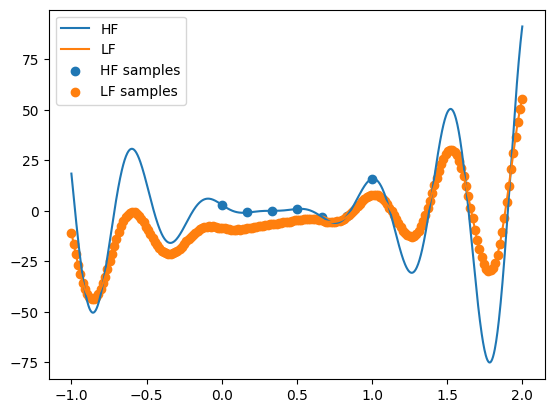

In [3]:
# generate the test points
test_samples = torch.linspace(-1, 2, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf_responses_noiseless = func.lf(test_samples, noise_lf=0.0)

# noise responses
test_hf_responses = func.hf(test_samples)
test_lf_responses = func.lf(test_samples)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf_responses_noiseless, label="LF")
# plot test noisy responses
# ax.scatter(test_samples, test_hf_responses, label="HF noise responses")
# ax.scatter(test_samples, test_lf_responses, label="LF noise responses")
# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf_responses, label="LF samples")
plt.legend()
plt.show()

In [4]:
# train a mf-rbf-gpr model first
# to have a gpr model for this problem
samples_gpr = {"lf": lf_samples.numpy(), "hf": hf_samples.numpy()}
responses_gpr = {"lf": lf_responses.numpy(), "hf": hf_responses.numpy()}

# create the MFRBFGPR object
mfrbfgpr = MFRBFGPR(
    design_space=np.array([[0, 1]]), noise_prior=0.1, optimizer_restart=20
)
# train the model
mfrbfgpr.train(
    samples=samples_gpr,
    responses=responses_gpr,
)

# get prediciton for the MFRBFGPR object
y_mfrbfgpr, total_unc_mfrbfgpr = mfrbfgpr.predict(
    X=test_samples.numpy(), return_std=True
)

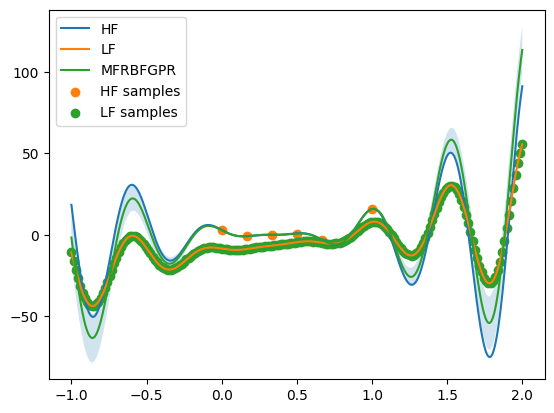

In [5]:
# plot the prediction
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf_responses_noiseless, label="LF")
# plot the prediction
ax.plot(test_samples, y_mfrbfgpr, label="MFRBFGPR")
# plot the uncertainty
ax.fill_between(
    test_samples.flatten(),
    (y_mfrbfgpr - 1.96 * total_unc_mfrbfgpr).flatten(),
    (y_mfrbfgpr + 1.96 * total_unc_mfrbfgpr).flatten(),
    alpha=0.2,
)
# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf_responses, label="LF samples")
plt.legend()
plt.show()

In [6]:
# the learned beta
print(mfrbfgpr.beta.T)

[[2.17814432 1.92581117]]


## Configurations for DNN and BNNs


In [7]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [20, 20],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.0001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.01,
    "sigma": 0.1,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.01,
    "sigma": 0.1,
}

# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

responses = {"lf": lf_responses, "hf": hf_responses}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 1000,
    "data_split": True,
}
hf_train_config = {
    "num_epochs": 10000,
    "sample_freq": 50,
    "print_info": True,
    "burn_in_epochs": 100,
}

# training of sequential MF-DNN-BNN model


In [8]:
# sequential mf-bnn
sequential_bnn = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)
# train the model
sequential_bnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

epoch:  1000 train loss:  0.6363628506660461 test loss:  0.49635589122772217
epoch:  2000 train loss:  0.3084713816642761 test loss:  0.33861303329467773
epoch:  3000 train loss:  0.04557337611913681 test loss:  0.06153160706162453
epoch:  4000 train loss:  0.006766081787645817 test loss:  0.0070169465616345406
epoch:  5000 train loss:  0.0038215680979192257 test loss:  0.004129354376345873
epoch:  6000 train loss:  0.002904914552345872 test loss:  0.003210602793842554
epoch:  7000 train loss:  0.0017354035517200828 test loss:  0.0017483379924669862
epoch:  8000 train loss:  0.0008144996245391667 test loss:  0.0007482937653549016
epoch:  9000 train loss:  0.00030148925725370646 test loss:  0.0002528110344428569
epoch:  10000 train loss:  0.00028110784478485584 test loss:  0.0002681798650883138
epoch:     0/10000
nll_loss: 12122.365, prior_loss: 2548.864, total: 14671.229
noise: 0.015


/home/yaga/Documents/mfbml/src/mfbml/methods/bnn.py:170: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:   100/10000
nll_loss: 409.198, prior_loss: 2588.272, total: 2997.470
noise: 0.015
epoch:   200/10000
nll_loss: 126.183, prior_loss: 2621.866, total: 2748.050
noise: 0.015
epoch:   300/10000
nll_loss: 183.506, prior_loss: 2661.675, total: 2845.181
noise: 0.015
epoch:   400/10000
nll_loss: 620.114, prior_loss: 2714.232, total: 3334.346
noise: 0.015
epoch:   500/10000
nll_loss: 22.331, prior_loss: 2778.088, total: 2800.419
noise: 0.015
epoch:   600/10000
nll_loss: 57.528, prior_loss: 2825.020, total: 2882.547
noise: 0.015
epoch:   700/10000
nll_loss: 923.802, prior_loss: 2910.984, total: 3834.786
noise: 0.015
epoch:   800/10000
nll_loss: 35.383, prior_loss: 2990.662, total: 3026.045
noise: 0.015
epoch:   900/10000
nll_loss: 37.903, prior_loss: 3027.990, total: 3065.893
noise: 0.015
epoch:  1000/10000
nll_loss: -2.345, prior_loss: 3083.780, total: 3081.435
noise: 0.015
epoch:  1100/10000
nll_loss: 181.202, prior_loss: 3169.558, total: 3350.760
noise: 0.015
epoch:  1200/10000
nll_los

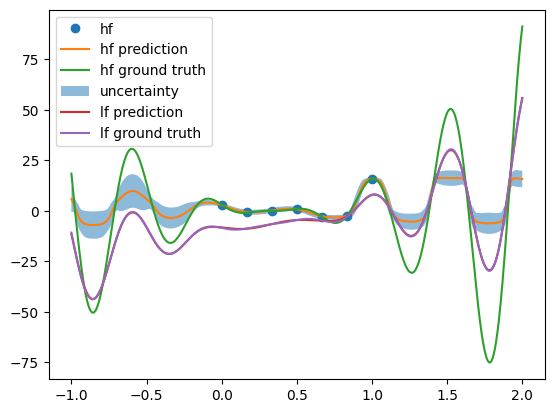

In [9]:
# visualize the posterior of sequential mf-bnn
(
    sequential_bnn_y,
    sequential_bnn_epistemic,
    sequential_bnn_total_unc,
    sequential_bnn_aleatoric,
) = sequential_bnn.predict(x=test_samples)
# get lf predictions
sequential_bnn_lf_y = sequential_bnn.predict_lf(x=test_samples)
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), sequential_bnn_y, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
ax.plot(test_samples.numpy(), sequential_bnn_lf_y.detach(), label="lf prediction")
ax.plot(
    test_samples.numpy(),
    test_lf_responses_noiseless.numpy(),
    label="lf ground truth",
)
ax.legend()
plt.show()

In [10]:
# create the MFDNNBNN object
mfdnnbnn = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=False,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn.beta = np.array([mfrbfgpr.beta[0, 0], mfrbfgpr.beta[1, 0]])
mfdnnbnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

epoch:  1000 train loss:  0.5626689791679382 test loss:  0.4535421133041382
epoch:  2000 train loss:  0.49387168884277344 test loss:  0.4514455497264862
epoch:  3000 train loss:  0.004919699393212795 test loss:  0.005158817395567894
epoch:  4000 train loss:  0.0022180736996233463 test loss:  0.002280340064316988
epoch:  5000 train loss:  0.0015995234716683626 test loss:  0.0016938257031142712
epoch:  6000 train loss:  0.0007241904968395829 test loss:  0.0006613669102080166
epoch:  7000 train loss:  0.0003825730236712843 test loss:  0.0003079526359215379
epoch:  8000 train loss:  0.0003389149496797472 test loss:  0.00028678501257672906
epoch:  9000 train loss:  0.000312473886879161 test loss:  0.00028163252864032984
epoch:  10000 train loss:  0.0002995592076331377 test loss:  0.0002849467855412513
optimized beta: [2.17814432 1.92581117]
epoch:     0/10000
nll_loss: 18481.375, prior_loss: 2508.311, total: 20989.686
noise: 0.015
epoch:   100/10000
nll_loss: 143.996, prior_loss: 2546.830, 

In [11]:
# predict the MFDNNBNN object
(
    y_proposed,
    epistemic_proposed,
    total_unc_proposed,
    aleatoric_proposed,
) = mfdnnbnn.predict(x=test_samples)
# lf prediction
lf_y_proposed = mfdnnbnn.predict_lf(test_samples)

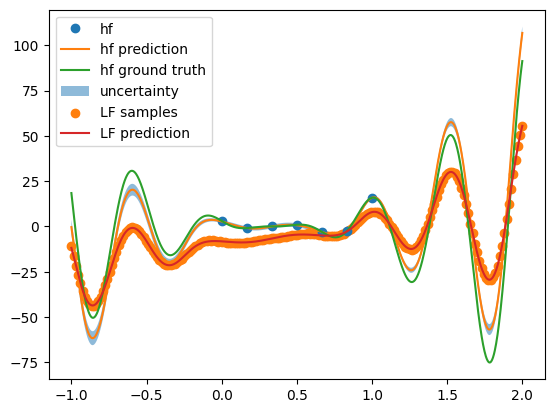

In [12]:
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * epistemic_proposed).reshape(-1),
    (y_proposed + 2 * epistemic_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

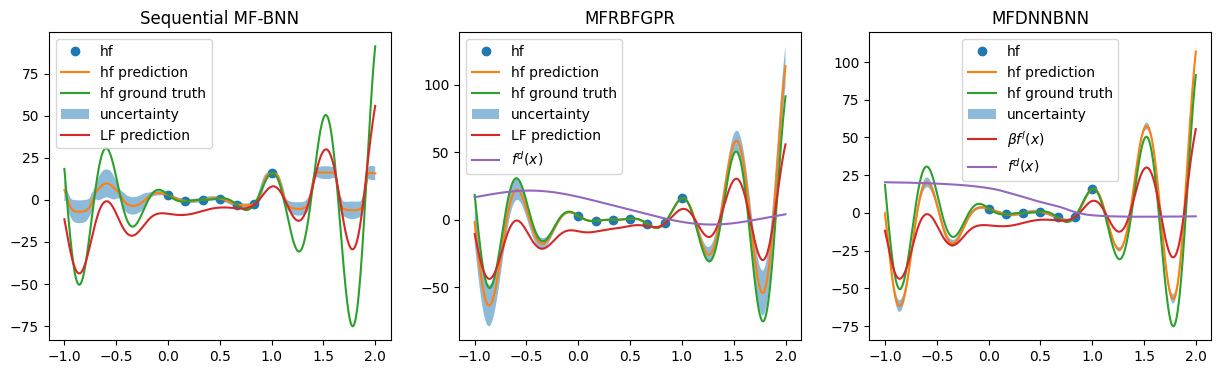

In [13]:
# plot two figures together
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# plot sequential mf-bnn
ax[0].plot(hf_samples, hf_responses, "o", label="hf")
ax[0].plot(test_samples.numpy(), sequential_bnn_y, label="hf prediction")
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax[0].fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
# ax[0].scatter(lf_samples, lf_responses, label="LF samples")
ax[0].plot(
    test_samples.numpy(), sequential_bnn_lf_y.detach().numpy(), label="LF prediction"
)
ax[0].legend()
ax[0].set_title("Sequential MF-BNN")
# ax[0].set_xlim([0, 1.5])

# plot MFRBFGPR
ax[1].plot(hf_samples, hf_responses, "o", label="hf")
ax[1].plot(test_samples.numpy(), y_mfrbfgpr, label="hf prediction")
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax[1].fill_between(
    test_samples.flatten().numpy(),
    (y_mfrbfgpr - 2 * total_unc_mfrbfgpr).reshape(-1),
    (y_mfrbfgpr + 2 * total_unc_mfrbfgpr).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
# ax[1].scatter(lf_samples, lf_responses, label="LF samples")
ax[1].plot(
    test_samples.numpy(),
    mfrbfgpr.lf_model.predict(test_samples.numpy()),
    label="LF prediction",
)
ax[1].plot(
    test_samples.numpy(),
    y_mfrbfgpr
    - mfrbfgpr.beta[1, 0] * mfrbfgpr.lf_model.predict(test_samples.numpy())
    - mfrbfgpr.beta[0, 0],
    label=r"$f^d(x)$",
)
ax[1].legend()
ax[1].set_title("MFRBFGPR")
# ax[1].set_xlim([0, 1.5])

# plot MFDNNBNN
ax[2].plot(hf_samples, hf_responses, "o", label="hf")
ax[2].plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax[2].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax[2].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
# ax[1].scatter(lf_samples, lf_responses, label="LF samples")
# ax[1].plot(test_samples.numpy(), lf_y_proposed.detach().numpy(), label="LF prediction")
ax[2].plot(
    test_samples.numpy(), lf_y_proposed.detach().numpy(), label=r"$\beta f^l(x) $"
)
ax[2].plot(
    test_samples.numpy(),
    y_proposed
    - mfrbfgpr.beta[1, 0] * lf_y_proposed.detach().numpy()
    - mfrbfgpr.beta[0, 0],
    label=r"$f^d(x)$",
)

ax[2].legend()
ax[2].set_title("MFDNNBNN")
# ax[1].set_xlim([0, 1.5])
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.svg", dpi=300, bbox_inches="tight")
plt.show()

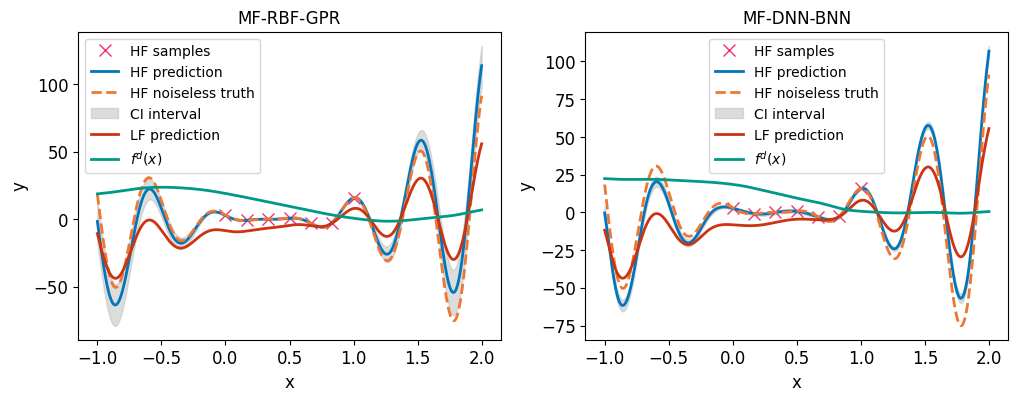

In [14]:
# plot comparison between
# plot two figures together
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(
    hf_samples,
    hf_responses,
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[0].plot(
    test_samples.numpy(),
    y_mfrbfgpr,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[0].fill_between(
    test_samples.flatten().numpy(),
    (y_mfrbfgpr - 2 * total_unc_mfrbfgpr).reshape(-1),
    (y_mfrbfgpr + 2 * total_unc_mfrbfgpr).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# plot lf samples
# ax[1].scatter(lf_samples, lf_responses, label="LF samples")
ax[0].plot(
    test_samples.numpy(),
    mfrbfgpr.lf_model.predict(test_samples.numpy()),
    "-",
    color="#CC3311",
    linewidth=2,
    label="LF prediction",
)
ax[0].plot(
    test_samples.numpy(),
    y_mfrbfgpr - 1.9144 * mfrbfgpr.lf_model.predict(test_samples.numpy()),
    label=r"$f^d(x)$",
    color="#009988",
    linewidth=2,
)

ax[0].legend()
ax[0].set_title("MF-RBF-GPR")
ax[0].set_xlabel("x", fontsize=12)
ax[0].set_ylabel("y", fontsize=12)
# set the font size of axis
ax[0].tick_params(axis="both", which="major", labelsize=12)
# ax[1].set_xlim([0, 1.5])

# plot MFDNNBNN
ax[1].plot(
    hf_samples,
    hf_responses,
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[1].plot(
    test_samples.numpy(),
    y_proposed,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[1].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# plot lf samples
# ax[1].scatter(lf_samples, lf_responses, label="LF samples")
# ax[1].plot(test_samples.numpy(), lf_y_proposed.detach().numpy(), label="LF prediction")
ax[1].plot(
    test_samples.numpy(),
    lf_y_proposed.detach().numpy(),
    "-",
    color="#CC3311",
    linewidth=2,
    label="LF prediction",
)
ax[1].plot(
    test_samples.numpy(),
    y_proposed - 1.9144 * lf_y_proposed.detach().numpy(),
    label=r"$f^d(x)$",
    color="#009988",
    linewidth=2,
)

ax[1].legend()
ax[1].set_title("MF-DNN-BNN")
ax[1].set_xlabel("x", fontsize=12)
ax[1].set_ylabel("y", fontsize=12)
# set the font size of axis
ax[1].tick_params(axis="both", which="major", labelsize=12)
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.svg", dpi=300, bbox_inches="tight")
plt.show()